In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
project_path = '/content/drive/MyDrive/DeepLearingProject '

zip_img_path = f"{project_path}/Images.zip"
txt_cap_path = f"{project_path}/captions.txt"

# img extracted will be at
extract_folders = '/content/imgs'


In [4]:
import zipfile

with zipfile.ZipFile(zip_img_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folders)

print("Imges are extracted to: ", extract_folders)

Imges are extracted to:  /content/imgs


In [5]:
# load vgg16 model
model = VGG16()

# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

# summarize
print(model.summary())

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 24s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [6]:
# extract features from the image

features = {}
directional = os.path.join(extract_folders, 'Images')

for img_name in tqdm(os.listdir(directional)):
    # load the image from file
    img_path = directional + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image id
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8090 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


In [7]:
# store features in pickel
pickle.dump(features, open(os.path.join(directional, 'features.pkl'), 'wb'))

In [8]:
import pickle

with open('/content/fea_reuse.pkl', 'wb') as f:
    pickle.dump(features, f)

print("✅ Features saved to /content/fea_reuse.pkl")


✅ Features saved to /content/fea_reuse.pkl


In [11]:
# load features from pickle
with open(os.path.join(directional, 'features.pkl'), 'rb') as f:
  features = pickle.load(f)


In [12]:
  #  load the captions data

  with open(txt_cap_path, 'r') as f:
    next(f)
    captions_doc = f.read()

In [13]:
with open('/content/fea_reuse.pkl', 'rb') as f:
    features = pickle.load(f)

In [14]:
captions_doc

'1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .\n1000268201_693b08cb0e.jpg,A girl going into a wooden building .\n1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .\n1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .\n1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .\n1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting\n1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .\n1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .\n1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .\n1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .\n1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .\n1002674143_1b742ab4b8.j

In [15]:
# create mapping of image to captions
mapping = {}

for line in tqdm(captions_doc.split('\n')):
  # split the line by comma
  tokens = line.split(',')
  if len(line) < 2:
    continue
  image_id, caption = tokens[0], tokens[1]
  # remove extension from img id
  image_id = image_id.split('.')[0]
  # convert caption to lowercase
  caption = "".join(caption)
  # create list needed
  if image_id not in mapping:
    mapping[image_id] = []
  # store the caption
  mapping[image_id].append(caption)


  0%|          | 0/40456 [00:00<?, ?it/s]

In [16]:
len(mapping)

8091

In [17]:
def clean(mapping):
  for key, captions in mapping.items():
    for i in range(len(captions)):
      # take one caption at a time
      caption = captions[i]
      # preprocess
      caption = caption.lower()
      caption = caption.replace('[^A-Za-z]','')
      caption = caption.replace('\s+',' ')
      # add start and end tags
      caption = '<start> '+" ".join([word for word in caption.split() if len(word)>1])+ ' <end>'
      captions[i] = caption


In [18]:
# before preprocess of text
mapping['1001773457_577c3a7d70']

['A black dog and a spotted dog are fighting',
 'A black dog and a tri-colored dog playing with each other on the road .',
 'A black dog and a white dog with brown spots are staring at each other in the street .',
 'Two dogs of different breeds looking at each other on the road .',
 'Two dogs on pavement moving toward each other .']

In [19]:
# preprocess the text
clean(mapping)

In [26]:
mapping['1001773457_577c3a7d70']

['<start> black dog and spotted dog are fighting <end>',
 '<start> black dog and tri-colored dog playing with each other on the road <end>',
 '<start> black dog and white dog with brown spots are staring at each other in the street <end>',
 '<start> two dogs of different breeds looking at each other on the road <end>',
 '<start> two dogs on pavement moving toward each other <end>']

In [20]:
all_captions = []
for key in mapping:
  for caption in mapping[key]:
    all_captions.append(caption)

In [21]:
len(all_captions)

40455

In [22]:
all_captions[:10]

['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start> girl going into wooden building <end>',
 '<start> little girl climbing into wooden playhouse <end>',
 '<start> little girl climbing the stairs to her playhouse <end>',
 '<start> little girl in pink dress going into wooden cabin <end>',
 '<start> black dog and spotted dog are fighting <end>',
 '<start> black dog and tri-colored dog playing with each other on the road <end>',
 '<start> black dog and white dog with brown spots are staring at each other in the street <end>',
 '<start> two dogs of different breeds looking at each other on the road <end>',
 '<start> two dogs on pavement moving toward each other <end>']

In [23]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [24]:
vocab_size

8311

In [25]:
# get maximum lengt of the captions availale
max_length = max(len(caption.split()) for caption in all_captions)
max_length

31

In [26]:
# train test split
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [27]:
# create data genertor to get data in batch (to avoid session crash)
def datagenerator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
  # loopover imgs
  X1, X2, y = list(), list(), list()
  n = 0
  while 1:
    for key in data_keys:
      n += 1
      captions = mapping[key]
      # process each caption
      for caption in captions:
        seq = tokenizer.texts_to_sequences([caption])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
          in_seq, out_seq = seq[:i], seq[i]
          # pad input sequence
          in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
          # encode output sequence
          out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

          # store the sequences
          X1.append(features[key][0])
          X2.append(in_seq)
          y.append(out_seq)
      if n == batch_size:
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
        yield (X1, X2), y
        X1, X2, y = list(), list(), list()
        n = 0

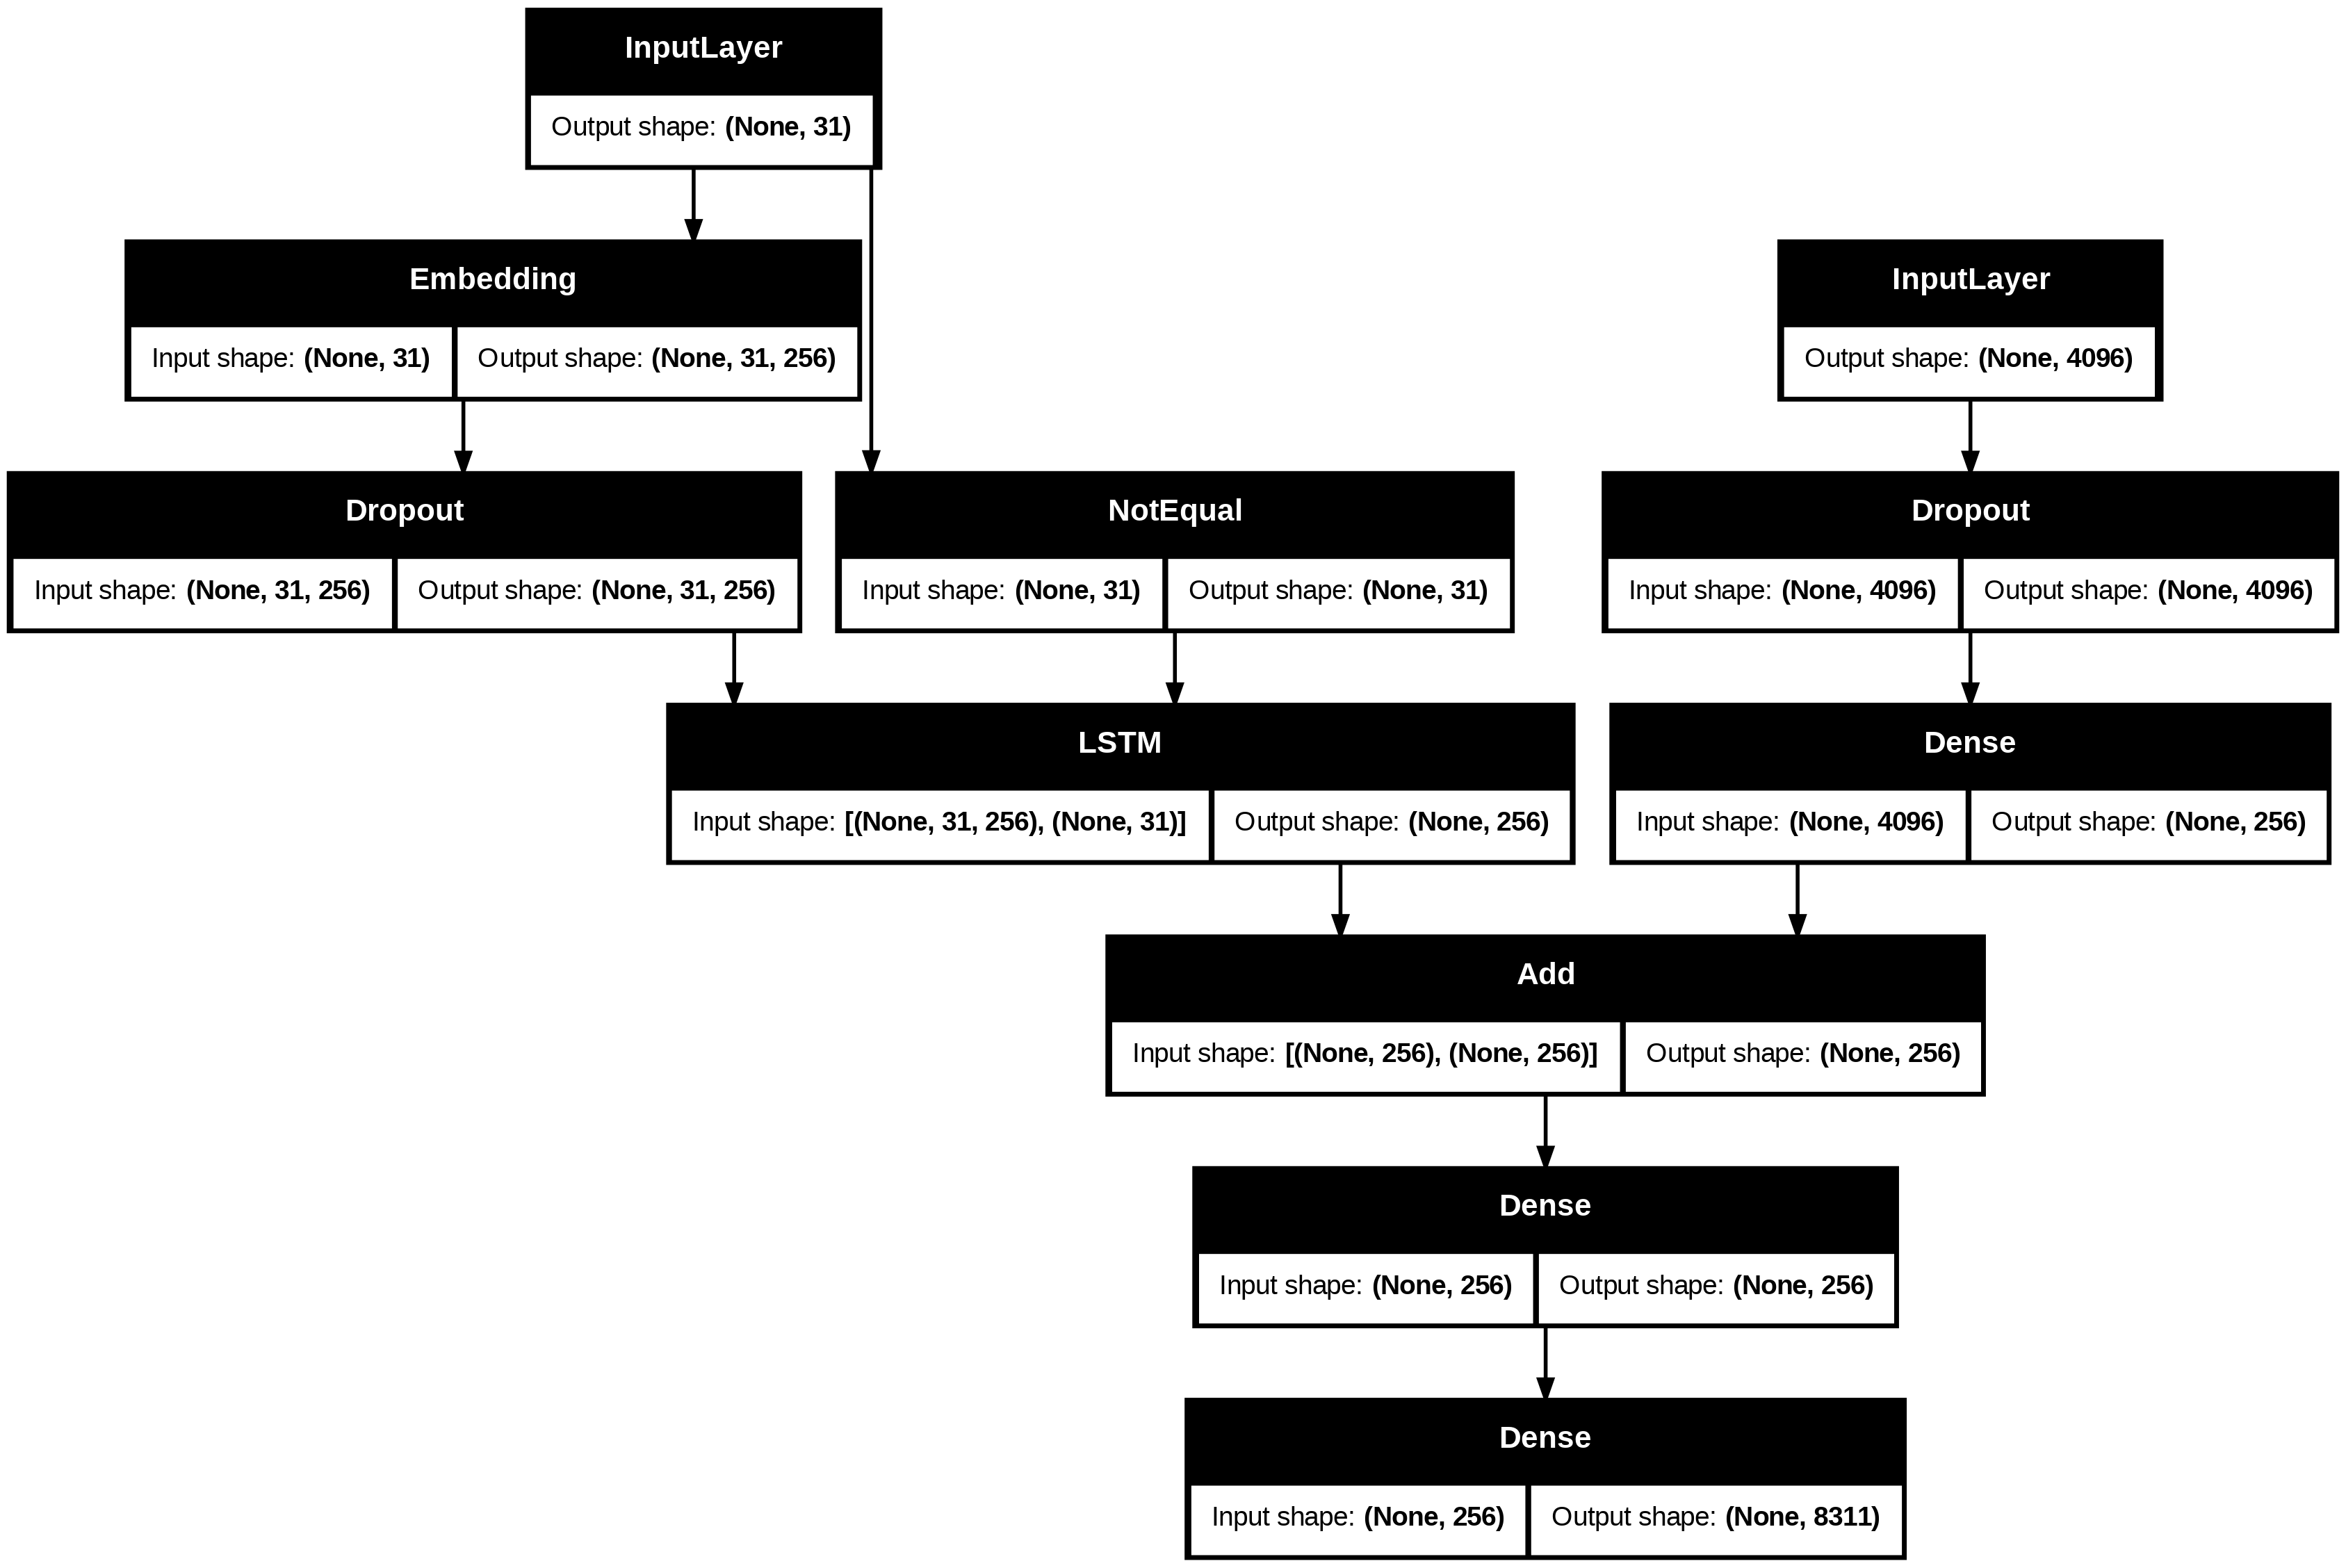

In [30]:
# modelcreation

# encoder model
# img feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# seq fature layers
inputs2 = Input(shape=(max_length,))
seq1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
seq2 = Dropout(0.4)(seq1)
seq3 = LSTM(256, return_sequences=False, recurrent_activation='sigmoid', activation='tanh', unroll=True)(seq2)




# decoder model
decoder1 = add([fe2, seq3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [32]:
import tensorflow as tf
print("TensorFlow is using:", tf.config.list_physical_devices())


TensorFlow is using: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [33]:
# ✅ FILTER: Keep only image-caption mappings where features exist
mapping = {k: v for k, v in mapping.items() if k in features}

# ✅ FILTER: Update train list accordingly
train = [img_id for img_id in train if img_id in features]

In [34]:
# train the model
epochs = 15
batch_size = 64
steps = len(train) // batch_size

for i in range(epochs):
  # create data generator
  generator = datagenerator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
  # fit for i epoch
  model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

113/113 ━━━━━━━━━━━━━━━━━━━━ 879s 8s/step - loss: 5.3331
113/113 ━━━━━━━━━━━━━━━━━━━━ 53s 469ms/step - loss: 4.1725
113/113 ━━━━━━━━━━━━━━━━━━━━ 52s 462ms/step - loss: 3.6470
113/113 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - loss: 3.3648
113/113 ━━━━━━━━━━━━━━━━━━━━ 51s 448ms/step - loss: 3.1656
113/113 ━━━━━━━━━━━━━━━━━━━━ 52s 461ms/step - loss: 3.0182
113/113 ━━━━━━━━━━━━━━━━━━━━ 52s 458ms/step - loss: 2.8966
113/113 ━━━━━━━━━━━━━━━━━━━━ 52s 459ms/step - loss: 2.7945
113/113 ━━━━━━━━━━━━━━━━━━━━ 51s 451ms/step - loss: 2.7070
113/113 ━━━━━━━━━━━━━━━━━━━━ 53s 466ms/step - loss: 2.6337
113/113 ━━━━━━━━━━━━━━━━━━━━ 54s 474ms/step - loss: 2.5738
113/113 ━━━━━━━━━━━━━━━━━━━━ 52s 460ms/step - loss: 2.5165
113/113 ━━━━━━━━━━━━━━━━━━━━ 53s 467ms/step - loss: 2.4694
113/113 ━━━━━━━━━━━━━━━━━━━━ 53s 471ms/step - loss: 2.4302
113/113 ━━━━━━━━━━━━━━━━━━━━ 53s 469ms/step - loss: 2.3812


In [35]:
# save the model
model.save('model.h5')

In [36]:
# Generate Captions for the image
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [40]:
# generate captions for the image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = '<start>'
    # iterate over max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == '<end>':
            break
    return in_text

In [38]:
from nltk.translate.bleu_score import corpus_bleu

In [41]:
# validate with text data
actual, predict = list(), list()

for key in tqdm(test):
  # get actual caption
  captions = mapping[key]
  # predict the caption for image
  y_pred = predict_caption(model, features[key], tokenizer, max_length)
  # split into words
  actual_captions = [caption.split() for caption in captions]
  y_pred = y_pred.split()
  # append to the list
  actual.append(actual_captions)
  predict.append(y_pred)

# calculate BLEU score
print('BLEU-1: %f' % corpus_bleu(actual, predict, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(actual, predict, weights=(0.5, 0.5, 0, 0)))



  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.182986
BLEU-2: 0.101079


In [42]:
# visualize the results
from PIL import Image
import matplotlib.pyplot as plt

In [43]:
def generate_captions(image_name):
    # load the img
    image_id = image_name.split('.')[0]
    img_path = os.path.join(extract_folders, 'Images', image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)

    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
<start> brown dog chases the water from sprinkler on lawn <end>
<start> brown dog plays with the hose <end>
<start> brown dog running on lawn near garden hose <end>
<start> dog is playing with hose <end>
<start> large brown dog running away from the sprinkler in the grass <end>
--------------------Predicted--------------------
<start> dog is running through green grass end end of hose end hose end of hose end hose end of hose end hose end of hose end end of hose end hose


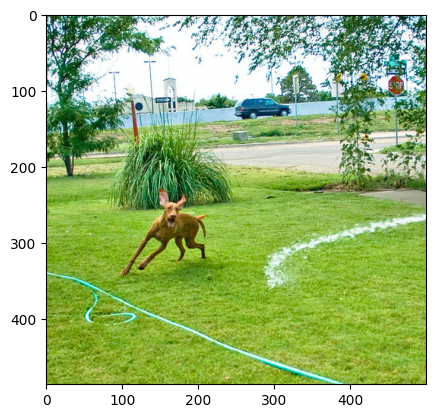

In [44]:
generate_captions('1019077836_6fc9b15408.jpg')